## Hacking 6 - Niave MLA - Does Naive Match the paper?

In [1]:
from transformers import AutoTokenizer
import torch

import sys
sys.path.append('DeepSeek-V3/inference') #Github slightly newer, I made some source code modification for datatype
# sys.path.append('DeepSeek-V3/DeepSeek-V3/inference') #Hugging face

from model import Transformer, MLA, ModelArgs, apply_rotary_emb
import matplotlib.pyplot as plt

from safetensors.torch import load_model, load_file
import os

In [2]:
save_dir='flowchart_graphics_4'
args=ModelArgs(**{"vocab_size": 129280,
                "dim": 7168,
                "inter_dim": 18432,
                "moe_inter_dim": 2048,
                "n_layers": 61,
                "n_dense_layers": 3,
                "n_heads": 128,
                "n_routed_experts": 256,
                "n_shared_experts": 1,
                "n_activated_experts": 8,
                "n_expert_groups": 8,
                "n_limited_groups": 4,
                "route_scale": 2.5,
                "score_func": "sigmoid",
                "q_lora_rank": 1536,
                "kv_lora_rank": 512,
                "qk_nope_head_dim": 128,
                "qk_rope_head_dim": 64,
                "v_head_dim": 128,
                "dtype": "bf16"}) #fp8 seems out due to my hardware? bf16

In [3]:
model=Transformer(args)

In [4]:
# ckpt_path='/home/stephen/deepseek/DeepSeek-V3/DeepSeek-V3'
ckpt_path='/home/stephen/deepseek/clean_hf_pull/DeepSeek-V3/weights_converted'
# ckpt_path='/home/stephen/deepseek/clean_hf_pull/DeepSeek-V3/weights_converted_2' ##Not enough RAM to load this puppy, could try a middle ground
# rank=0
# world_size=1

#
# missing, unexpected=load_model(model, os.path.join(ckpt_path, 'model-00001-of-000163.safetensors'), strict=False)
# load_model(model, os.path.join(ckpt_path, 'model-00009-of-000163.safetensors'), strict=False)
# missing, unexpected=load_model(model, os.path.join(ckpt_path, "model0-mp1.safetensors"), strict=False) #Result of conversion process

state_dict = load_file(os.path.join(ckpt_path, "model0-mp1.safetensors"), device='cpu')
model_state_dict=model.state_dict()

In [5]:
missing, unexpected = model.load_state_dict(state_dict, strict=False)

In [6]:
len(state_dict), len(missing), len(unexpected)

(846, 44960, 411)

In [7]:
model.layers[0].attn.wq_a.weight.detach().abs().sum()

tensor(7.5078e+08, dtype=torch.bfloat16)

In [8]:
tokenizer = AutoTokenizer.from_pretrained('/home/stephen/deepseek/DeepSeek-V3/DeepSeek-V3')

In [9]:
tokens=tokenizer.encode("The American flag is red, white, and")
logits=model.forward(torch.tensor([tokens]), start_pos=0) #Dope! Ran on CPU somehow - took a couple minutes. 

In [10]:
tokens

[0, 671, 3707, 14364, 344, 4332, 14, 5403, 14, 305]

## Setup for Forward Pass

In [11]:
start_pos=0 #might need to noodle with this to understad caching
seqlen = torch.tensor([tokens]).size(1)
freqs_cis = model.freqs_cis[start_pos:start_pos+seqlen]

mask = None
if seqlen > 1:
    mask = torch.full((seqlen, seqlen), float("-inf"), device='cpu').triu_(1) #CPUing for now

start_pos, seqlen, freqs_cis.shape, mask.shape

(0, 10, torch.Size([10, 32]), torch.Size([10, 10]))

In [12]:
h = model.embed(torch.tensor([tokens]))

In [13]:
h_out=model.layers[0].attn.forward(h, start_pos, freqs_cis, mask) #Run MLA forward pass from outside

In [14]:
h_out_reference=h_out #Use for some rough unit testing that my pipeline is working

In [15]:
h_out_reference #Hmm thos numbers seem big! Maybe it's ok?

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [1171456.,   91648.,  468992.,  ...,  729088.,  667648., -152576.],
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

## Walk Through Niave Forward Pass

In [16]:
x=h
mla=model.layers[0].attn

In [17]:
bsz, seqlen, _ = x.size()
end_pos = start_pos + seqlen
if mla.q_lora_rank == 0:
    q = self.wq(x)
else:
    q = mla.wq_b(mla.q_norm(mla.wq_a(x)))
    print('hay')

hay


In [19]:
h1=mla.wq_a(x)
h2=mla.q_norm(mla.wq_a(x))
q=mla.wq_b(mla.q_norm(mla.wq_a(x))) #Probably not going to worry about query compresssion

In [20]:
q = q.view(bsz, seqlen, mla.n_local_heads, mla.qk_head_dim) #Ok splitting out the queries across all the heads

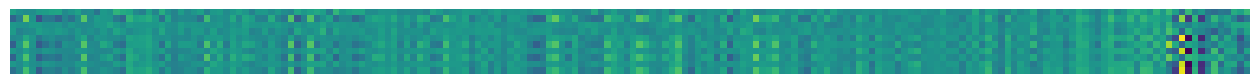

In [22]:
head_id=0
q_to_viz=q[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [23]:
q_nope, q_pe = torch.split(q, [mla.qk_nope_head_dim, mla.qk_rope_head_dim], dim=-1)

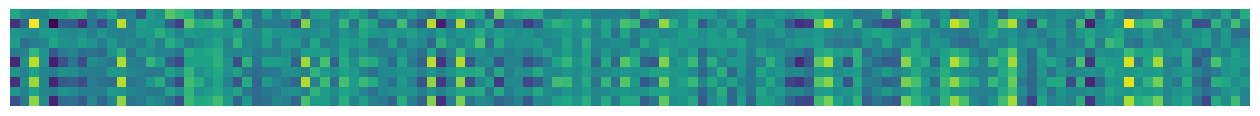

In [24]:
q_to_viz=q_nope[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_nope.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

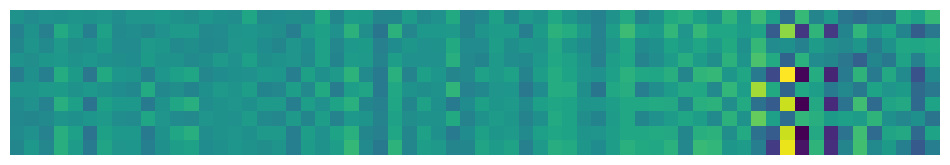

In [25]:
q_to_viz=q_pe[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(12,6))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_pe.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [26]:
q_pe = apply_rotary_emb(q_pe, freqs_cis)

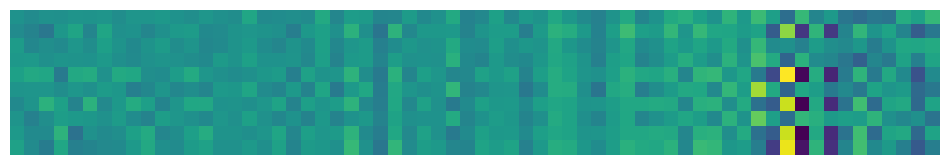

In [27]:
q_to_viz=q_pe[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(12,6))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_pe_after_embedding.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [43]:
kv = mla.wkv_a(x)

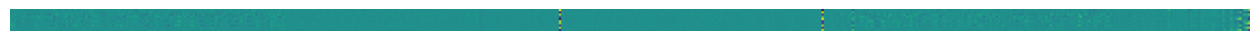

In [44]:
to_viz=kv[0,:,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [45]:
kv, k_pe = torch.split(kv, [mla.kv_lora_rank, mla.qk_rope_head_dim], dim=-1)
k_pe = apply_rotary_emb(k_pe.unsqueeze(2), freqs_cis)

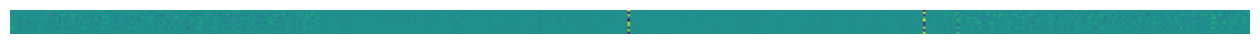

In [46]:
to_viz=kv[0,:,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

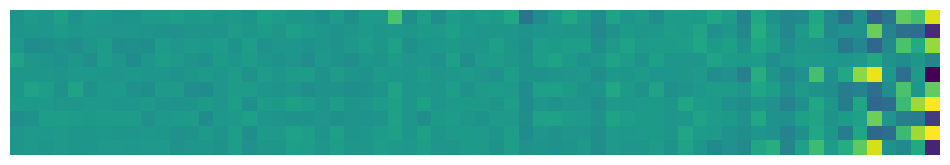

In [47]:
to_viz=k_pe[0,:,0,:].detach().cpu().float().numpy()
fig=plt.figure(0,(12,6))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kpe.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

### Ok now we're in the Niave implementation

In [48]:
q = torch.cat([q_nope, q_pe], dim=-1)

In [49]:
q.shape

torch.Size([1, 10, 128, 192])

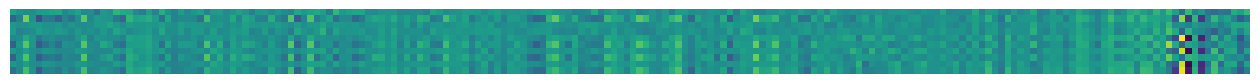

In [50]:
head_id=0
to_viz=q[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_final.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [52]:
kv.shape

torch.Size([1, 10, 512])

In [51]:
mla.kv_norm(kv).shape

torch.Size([1, 10, 512])

In [53]:
kv = mla.wkv_b(mla.kv_norm(kv))

In [56]:
kv.shape #Ok this is more like what I expected - "up projecting latent space kv cache"

torch.Size([1, 10, 32768])

In [58]:
kv = kv.view(bsz, seqlen, mla.n_local_heads, mla.qk_nope_head_dim + mla.v_head_dim)

In [59]:
kv.shape

torch.Size([1, 10, 128, 256])

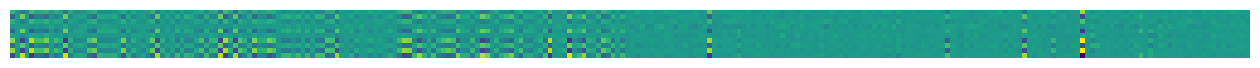

In [60]:
head_id=0
to_viz=kv[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv_up_projected.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [63]:
k_nope, v = torch.split(kv, [mla.qk_nope_head_dim, mla.v_head_dim], dim=-1)

In [64]:
k_nope.shape

torch.Size([1, 10, 128, 128])

In [65]:
v.shape

torch.Size([1, 10, 128, 128])

Hmm ok I'll want to trace this tomorrow in a flow chart, splitting out k and v -> I guess that make sense after up projection...

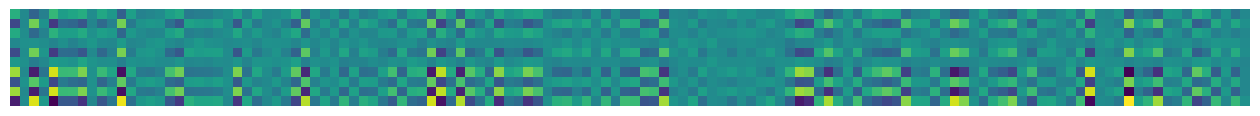

In [66]:
head_id=0
to_viz=k_nope[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/k_nope.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

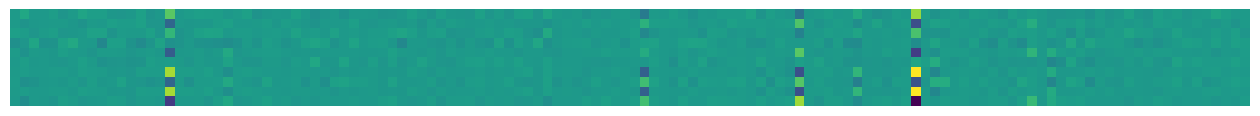

In [67]:
head_id=0
to_viz=v[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/v.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

Interesting that even though they come from the same place, the keys and values up projected seem to have sorta different structure?

In [69]:
k = torch.cat([k_nope, k_pe.expand(-1, -1, mla.n_local_heads, -1)], dim=-1)

In [70]:
k.shape

torch.Size([1, 10, 128, 192])

## Ok nevermind, I don't think that naive means "Niave MLA" - Man Shoot this makes no sense. Maybe I look at paper next. 

In [ ]:
self.k_cache[:bsz, start_pos:end_pos] = k #Wait I thought these were unembedded???
self.v_cache[:bsz, start_pos:end_pos] = v

In [ ]:
scores = torch.einsum("bshd,bthd->bsht", q, self.k_cache[:bsz, :end_pos]) * self.softmax_scale